In [14]:
%%capture
!pip install swig
!pip install gymnasium[box2d]
!pip install ray[rllib]
!pip install renderlab

In [3]:
import matplotlib.pyplot as plt
import gymnasium as gym
import ray
from ray.rllib.algorithms.ppo import PPOConfig

/usr/local/lib/python3.10/dist-packages/flax/configurations.py:42: DeprecationWarning: jax.config.define_bool_state is deprecated. Please use other libraries for configuration instead.
  return jax_config.define_bool_state('flax_' + name, default, help)
2023-12-17 14:56:54,505	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
2023-12-17 14:56:58,372	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore hav

**API Info**

The Core Gym enviroment has 3 main functions

- **Step**: A timestep of the enviroment dynamics, which is an action given by the agent. As a return, the enviroment will provide observations for the action, as well as the reward, info helpfull for debugging, and 2 boolean values, terminated and truncated, which indicate weather the action results to a terminal state or a truncation which is a permature termination for various reasons like time limit.

- **Rest**: It simply resets the enviroment to the initial state and returns the initial observation, similar to a step observation. Reset can have 2 optional parameters: seed and options, both related to the the initial state of the enviroment.

- **Render**: The enviroment gives a rendered computation of the enviroment

**Lunar Lander**

For Lunar Lander, the observation space returned by the actions and reset functions is a 8-dimensional vector:
- X coordinates
- Y coordinated
- X linear velocity
- Y linear velocity
- Angle
- Angular velocity
- Leg 1 is in contact with the ground (Yes/No)
- Leg 2 is in contact with the ground (Yes/No)

As actions, the agent can provide/do the following:
- Do nothing
- Fire left oriantation engine
- Fire left oriantation engine
- Fire main engine

# Compute PPO Agent

In [15]:
%%capture
ray.shutdown()
ray.init()

config = PPOConfig()
config.use_critic = True
config.use_gae = True
config.lambda_ = 0.95
config.use_kl_loss = True
config.sgf_minibatch_size = 32
config.num_sgd_iter = 30
config.shuffle_sequences = True
config.vf_loss_coeff = 0.5
config.entropy_coeff = 0.001
config.clip_param = 0.2

agent = config.environment("LunarLander-v2").framework(framework='tf').build()

2023-12-17 15:17:10,929	INFO worker.py:1673 -- Started a local Ray instance.
2023-12-17 15:17:31,965	INFO trainable.py:164 -- Trainable.setup took 18.318 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-12-17 15:17:31,973	WARNING util.py:62 -- Install gputil for GPU system monitoring.


In [16]:
agent.get_policy().model.base_model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 observations (InputLayer)   [(None, 8)]                  0         []                            
                                                                                                  
 fc_1 (Dense)                (None, 256)                  2304      ['observations[0][0]']        
                                                                                                  
 fc_value_1 (Dense)          (None, 256)                  2304      ['observations[0][0]']        
                                                                                                  
 fc_2 (Dense)                (None, 256)                  65792     ['fc_1[0][0]']                
                                                                                              

Iteration 1, Average Rewards: -177.64558765093182
Iteration 2, Average Rewards: -161.11196732409857
Iteration 3, Average Rewards: -138.69688706404344
Iteration 4, Average Rewards: -121.33870071963041
Iteration 5, Average Rewards: -100.22314342908003
Iteration 6, Average Rewards: -81.31402116866262
Iteration 7, Average Rewards: -64.87467954659871
Iteration 8, Average Rewards: -53.99662106670406
Iteration 9, Average Rewards: -50.21789651130982
Iteration 10, Average Rewards: -49.945611576740895
Iteration 11, Average Rewards: -44.04038606019254
Iteration 12, Average Rewards: -41.10156915320486
Iteration 13, Average Rewards: -38.54572915713313
Iteration 14, Average Rewards: -33.47627248715653
Iteration 15, Average Rewards: -38.33704111649501
Iteration 16, Average Rewards: -36.69004781687965
Iteration 17, Average Rewards: -35.45984215764844
Iteration 18, Average Rewards: -33.220326748535804
Iteration 19, Average Rewards: -30.47388400902992
Iteration 20, Average Rewards: -28.82123598566362
It

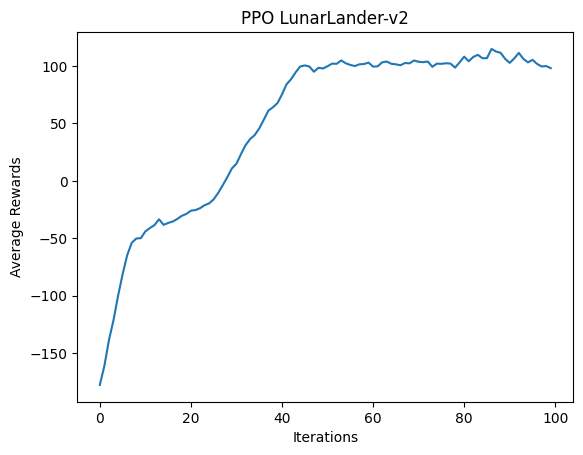

In [17]:
train_iterations = 100
average_rewards_per_iteration = []

for i in range(train_iterations):
  log = agent.train()
  average_rewards = log['sampler_results']['episode_reward_mean']
  average_rewards_per_iteration.append(average_rewards)

  print(f'Iteration {i+1}, Average Rewards: {average_rewards}')

plt.plot(average_rewards_per_iteration)
plt.title('PPO LunarLander-v2')
plt.xlabel('Iterations')
plt.ylabel('Average Rewards')
plt.show()

We can see the Agent got trained and the Average Rewards obtained increased (until a certain point at least)

In [22]:
import renderlab as rl

env = gym.make("LunarLander-v2", render_mode = "rgb_array")
env = rl.RenderFrame(env, "./output")

observation, info = env.reset()

while True:
  action = agent.compute_single_action(observation)
  observation, reward, terminated, truncated, info = env.step(action)

  if terminated or truncated:
    break

env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Could be better to be honest